# Lesson 10 — Decision Trees, Bagging, and Random Forests (CS229-style)

This version emphasizes **Random Forests** (bagging + feature randomness) and adds:
- **Decision regions + vote probability heatmaps** (clear ensemble intuition)
- A **small tree visualizer** (matplotlib) so you can *see* what a learned tree looks like

> Note: The earlier 3D “vote surface” is technically a visualization of the forest’s **vote probability** over the 2D plane,
but it looks “blocky” because trees create **piecewise-constant** predictions. For intuition, **2D probability heatmaps** are usually better.


## Outline
1. Entropy + Information Gain  
2. A small decision tree (depth-limited) built greedily  
3. Bagging (bootstrap aggregation)  
4. Random Forests (bagging + random feature subsets at each split)  
5. Visualizations:
   - stump/tree split intuition
   - **vote probability heatmap**
   - **tree diagram**


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(0)

## 1) Data: XOR (ensembles shine here)

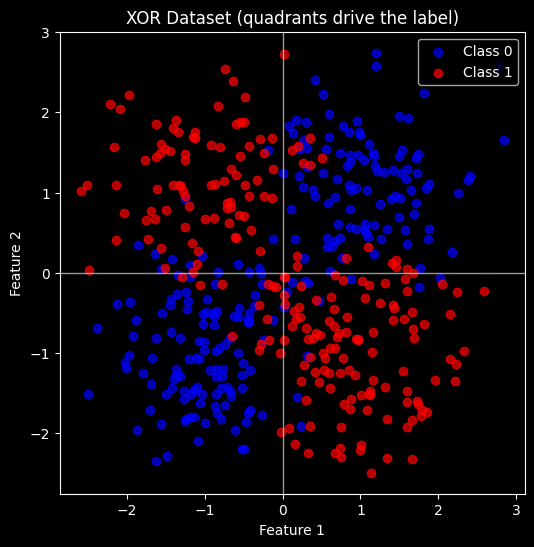

In [13]:
# XOR dataset: not linearly separable, trees/forests handle it naturally
n = 450
X = np.random.uniform(-2, 2, size=(n,2))
y = ((X[:,0] > 0) ^ (X[:,1] > 0)).astype(int)
X = X + 0.35*np.random.randn(n,2)

plt.figure(figsize=(6,6))
plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.7, label="Class 0")
plt.scatter(X[y==1,0], X[y==1,1], color="red",  alpha=0.7, label="Class 1")
plt.axvline(0, color="white", linewidth=1, alpha=0.6)
plt.axhline(0, color="white", linewidth=1, alpha=0.6)
plt.title("XOR Dataset (quadrants drive the label)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right")
plt.show()

## 2) Entropy + Information Gain

In [14]:
def entropy(y):
    counts = Counter(y)
    probs = np.array(list(counts.values()), dtype=float) / len(y)
    return -np.sum(probs * np.log2(probs + 1e-12))

def information_gain(X_col, y, threshold):
    left = y[X_col <= threshold]
    right = y[X_col > threshold]
    if len(left)==0 or len(right)==0:
        return 0.0
    return entropy(y) - (
        len(left)/len(y)*entropy(left) +
        len(right)/len(y)*entropy(right)
    )

## 3) A small greedy decision tree (depth-limited)
We’ll build a **depth-limited** tree using information gain.

In [15]:
def best_split(X, y, feature_subset=None):
    best = {"gain": -1.0}
    d = X.shape[1]
    features = range(d) if feature_subset is None else feature_subset

    for j in features:
        for t in np.unique(X[:,j]):
            ig = information_gain(X[:,j], y, t)
            if ig > best["gain"]:
                best = {"feature": j, "threshold": float(t), "gain": float(ig)}
    return best

def majority_label(y):
    return Counter(y).most_common(1)[0][0]

def train_tree(X, y, max_depth=3, min_samples=10, mtry=None):
    if max_depth == 0 or len(y) < min_samples or len(set(y)) == 1:
        return {"leaf": True, "pred": int(majority_label(y)), "n": int(len(y))}

    d = X.shape[1]
    if mtry is None:
        feat_subset = None
    else:
        feat_subset = np.random.choice(d, size=mtry, replace=False)

    split = best_split(X, y, feature_subset=feat_subset)

    if split["gain"] <= 1e-12:
        return {"leaf": True, "pred": int(majority_label(y)), "n": int(len(y))}

    j, t = split["feature"], split["threshold"]
    left_idx = X[:,j] <= t
    right_idx = ~left_idx

    node = {
        "leaf": False,
        "feature": int(j),
        "threshold": float(t),
        "gain": float(split["gain"]),
        "n": int(len(y)),
        "left": train_tree(X[left_idx], y[left_idx], max_depth-1, min_samples, mtry),
        "right": train_tree(X[right_idx], y[right_idx], max_depth-1, min_samples, mtry),
    }
    return node

def predict_tree_one(x, node):
    while not node["leaf"]:
        if x[node["feature"]] <= node["threshold"]:
            node = node["left"]
        else:
            node = node["right"]
    return node["pred"]

def predict_tree(X, node):
    return np.array([predict_tree_one(x, node) for x in X], dtype=int)

### Train a single tree and view its decision regions

In [16]:
tree = train_tree(X, y, max_depth=3, min_samples=10, mtry=None)
pred_tree = predict_tree(X, tree)
print("Single tree train accuracy:", np.mean(pred_tree == y))

Single tree train accuracy: 0.8933333333333333


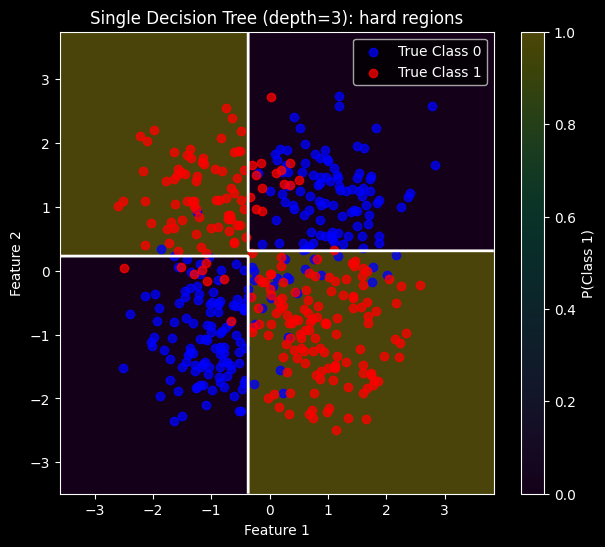

In [17]:
def plot_decision_regions_prob(X, y, prob_fn, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    P = prob_fn(grid).reshape(xx.shape)

    plt.figure(figsize=(7,6))
    im = plt.imshow(P, origin="lower",
                    extent=(x_min, x_max, y_min, y_max),
                    aspect="auto", alpha=0.30)
    cbar = plt.colorbar(im)
    cbar.set_label("P(Class 1)")

    plt.contour(xx, yy, P, levels=[0.5], colors="white", linewidths=2)

    plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.75, label="True Class 0")
    plt.scatter(X[y==1,0], X[y==1,1], color="red",  alpha=0.75, label="True Class 1")

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.show()

plot_decision_regions_prob(
    X, y,
    prob_fn=lambda Xg: predict_tree(Xg, tree).astype(float),
    title="Single Decision Tree (depth=3): hard regions"
)

## 4) Bagging and Random Forests
Bagging = bootstrap samples. Random Forest = bagging + **random feature subsets at each split** (mtry).

In [18]:
def bagging_forest_vote_prob(X_train, y_train, X_query, B=200, max_depth=3, min_samples=10, mtry=None):
    votes = np.zeros(len(X_query), dtype=float)
    n = len(X_train)
    for _ in range(B):
        idx = np.random.choice(n, n, replace=True)
        t = train_tree(X_train[idx], y_train[idx], max_depth=max_depth, min_samples=min_samples, mtry=mtry)
        votes += predict_tree(X_query, t)
    return votes / B  # fraction voting class 1

### Bagging (trees) vs Random Forests (trees + feature randomness)

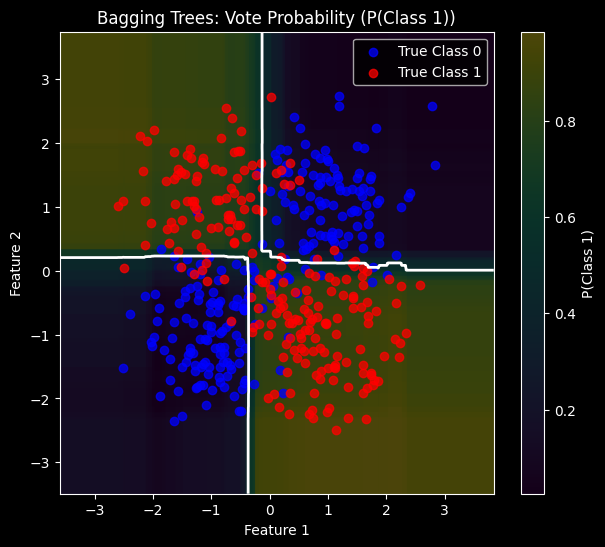

In [19]:
P_bag = lambda Xg: bagging_forest_vote_prob(X, y, Xg, B=200, max_depth=3, mtry=None)
P_rf  = lambda Xg: bagging_forest_vote_prob(X, y, Xg, B=200, max_depth=3, mtry=1)  # for 2D, mtry=1

plot_decision_regions_prob(X, y, P_bag, "Bagging Trees: Vote Probability (P(Class 1))")

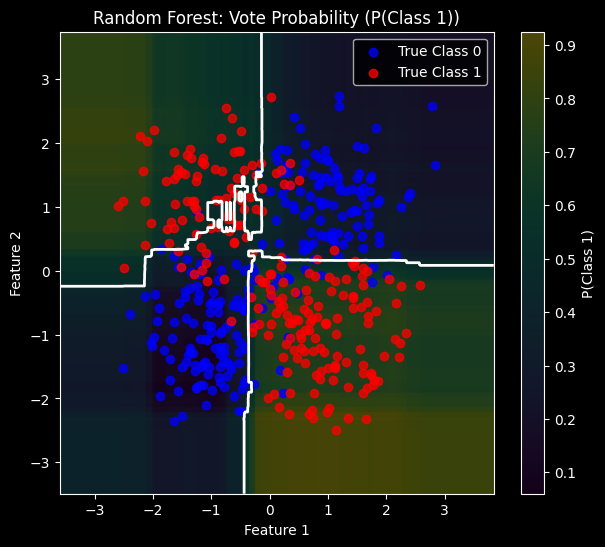

In [20]:
plot_decision_regions_prob(X, y, P_rf,  "Random Forest: Vote Probability (P(Class 1))")

In [29]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_vote_surface_3d_pins(X, y, vote_prob_fn, title, n_points=180, show_pins=True):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 90),
        np.linspace(y_min, y_max, 90)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = vote_prob_fn(grid).reshape(xx.shape)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")

    # Surface: cleaner look (no wire grid)
    ax.plot_surface(xx, yy, Z, alpha=0.40, linewidth=1, antialiased=True)

    # Subsample points
    idx = np.random.choice(len(X), size=min(n_points, len(X)), replace=False)
    Xs = X[idx]
    ys = y[idx]

    # Vote probability at those points
    p = vote_prob_fn(Xs).reshape(-1)
    eps = 0.02
    z_pts = np.clip(p + eps, 0, 1)

    # Optional "pins" down to the surface value p (before eps)
    if show_pins:
        for i in range(len(Xs)):
            ax.plot([Xs[i,0], Xs[i,0]],
                    [Xs[i,1], Xs[i,1]],
                    [p[i], z_pts[i]],
                    color="grey", alpha=0.40, linewidth=1)

    # Points sit just above surface
    ax.scatter(Xs[ys==0,0], Xs[ys==0,1], z_pts[ys==0],
               color="blue", alpha=0.85, s=22, depthshade=False, label="Class 0")
    ax.scatter(Xs[ys==1,0], Xs[ys==1,1], z_pts[ys==1],
               color="red", alpha=0.85, s=22, depthshade=False, label="Class 1")
    ax.contour(xx, yy, Z, levels=[0.5], colors="white", linewidths=3, offset=0.5)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Vote probability (Class 1)")
    ax.set_zlim(0, 1)
    ax.set_title(title)

    # Camera (your angle is fine—this one tends to read well)
    ax.view_init(elev=22, azim=120)
    ax.legend(loc="upper right")
    plt.show()


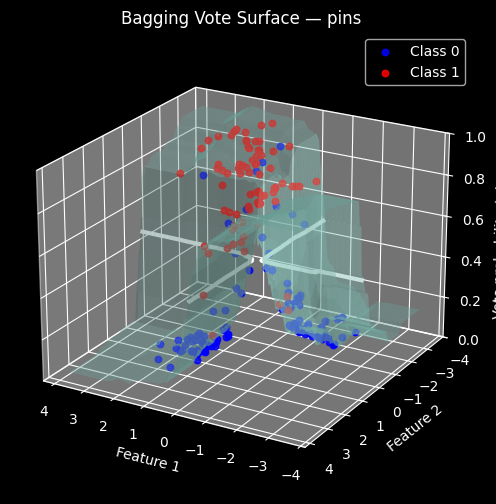

In [30]:
vote_prob_fn = lambda Xg: bagging_forest_vote_prob(X, y, Xg, B=200)
plot_vote_surface_3d_pins(X, y, vote_prob_fn, "Bagging Vote Surface — pins", show_pins=True)

## 5) Visualize an actual learned tree (matplotlib)
This is a simple tree diagram renderer for small depth trees.

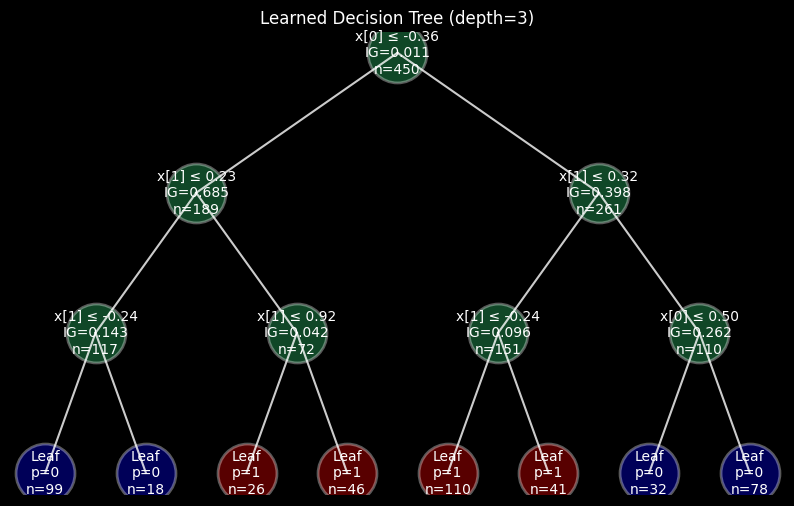

In [27]:
def layout_tree(node, x=0.0, y=0.0, dx=1.0, coords=None, edges=None, depth=0):
    if coords is None: coords = {}
    if edges is None: edges = []

    nid = id(node)
    coords[nid] = (x, y, node)

    if not node["leaf"]:
        left = node["left"]; right = node["right"]
        x_left  = x - dx/(2**depth)
        x_right = x + dx/(2**depth)
        y_child = y - 1

        edges.append((nid, id(left)))
        edges.append((nid, id(right)))

        layout_tree(left,  x_left,  y_child, dx, coords, edges, depth+1)
        layout_tree(right, x_right, y_child, dx, coords, edges, depth+1)

    return coords, edges

def draw_tree(node, title="Decision Tree"):
    coords, edges = layout_tree(node, x=0.0, y=0.0, dx=4.0)

    plt.figure(figsize=(10,6))
    for a, b in edges:
        xa, ya, _ = coords[a]
        xb, yb, _ = coords[b]
        plt.plot([xa, xb], [ya, yb], color="white", linewidth=1.5, alpha=0.8)

    for nid, (x, y, nd) in coords.items():
        if nd["leaf"]:
            txt = f"Leaf\np={nd['pred']}\nn={nd['n']}"
            fc = "red" if nd["pred"]==1 else "blue"
        else:
            txt = f"x[{nd['feature']}] ≤ {nd['threshold']:.2f}\nIG={nd['gain']:.3f}\nn={nd['n']}"
            fc = "#2ecc71"
        plt.scatter([x], [y], s=1800, color=fc, alpha=0.35, edgecolors="white", linewidths=2)
        plt.text(x, y, txt, ha="center", va="center", color="white", fontsize=10)

    plt.title(title)
    plt.axis("off")
    plt.show()

draw_tree(tree, title="Learned Decision Tree (depth=3)")

## Key Takeaways (Lesson 10)

- **Decision Trees** partition space into axis-aligned rectangles (piecewise-constant predictions).  
- Trees are **high-variance** learners: small changes in data can change splits a lot.  
- **Bagging** reduces variance by averaging many trees trained on bootstrap samples.  
- **Random Forests** add *feature randomness* at each split (mtry), which decorrelates trees and improves averaging.  
- The most intuitive ensemble visualization is the **vote probability heatmap**:
  - low regions = forest leans Class 0
  - high regions = forest leans Class 1
  - the 0.5 contour is the decision boundary
